In [1]:
import tensorflow as tf
import os
import struct
import numpy as np
from matplotlib import pyplot as plt


print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
print(os.getcwd())
mnist_train = "{}\\data\\Mnist\\train".format(os.getcwd())
mnist_test = "{}\\data\\Mnist\\test".format(os.getcwd())
test_labels_file = "{}\\labels\\t10k-labels.idx1-ubyte".format(mnist_test)
test_images_file = "{}\\images\\t10k-images.idx3-ubyte".format(mnist_test)
train_labels_file = "{}\\labels\\train-labels.idx1-ubyte".format(mnist_train)
train_images_file = "{}\\images\\train-images.idx3-ubyte".format(mnist_train)
print("test, train, labels and images combinations are listed below, if there are less than 4 then the paths need to be changed")
if os.path.isfile(test_labels_file): print(test_labels_file)
if os.path.isfile(test_images_file): print(test_images_file)
if os.path.isfile(train_labels_file): print(train_labels_file)
if os.path.isfile(train_images_file): print(train_images_file)
print("--------------")

C:\Users\zanza\Desktop\FOLDERS\work_projects\police\prelim_work
test, train, labels and images combinations are listed below, if there are less than 4 then the paths need to be changed
C:\Users\zanza\Desktop\FOLDERS\work_projects\police\prelim_work\data\Mnist\test\labels\t10k-labels.idx1-ubyte
C:\Users\zanza\Desktop\FOLDERS\work_projects\police\prelim_work\data\Mnist\test\images\t10k-images.idx3-ubyte
C:\Users\zanza\Desktop\FOLDERS\work_projects\police\prelim_work\data\Mnist\train\labels\train-labels.idx1-ubyte
C:\Users\zanza\Desktop\FOLDERS\work_projects\police\prelim_work\data\Mnist\train\images\train-images.idx3-ubyte
--------------


In [3]:
def mnist_file_parser(file_path, file_type): #format as documented in Yanns mnist documentation
    if file_type != "labels" and file_type != "images":
        print("unrecognized file type")
        return
    
    if file_type == "labels":
        with open(file_path, "rb") as f:
            f = f.read()
            magic_num = struct.unpack_from(">i",f,offset=0)[0]
            size = struct.unpack_from(">i",f,offset=4)[0]
            unpacked = struct.unpack_from(">{}B".format(size),f,offset=8)
            print("magic_num: {}, size {} == {}".format(magic_num,size,len(unpacked)))
        result_np_arr = np.asarray(unpacked)
        return result_np_arr
    
    elif file_type == "images":
        with open(file_path, "rb") as f:
            f = f.read()
            magic_num = struct.unpack_from(">i",f,offset=0)[0]
            size = struct.unpack_from(">i",f,offset=4)[0]
            nrow = struct.unpack_from(">i",f,offset=8)[0]
            ncol = struct.unpack_from(">i",f,offset=12)[0]
            unpacked = struct.unpack_from(">{}B".format(size*nrow*ncol),f,offset=16)
            print("magic_num: {},nrow({}),ncol({}), size {}*nrow*ncol == {}".format(magic_num,nrow,ncol,size,len(unpacked)))
        result_np_arr = np.asarray(unpacked).reshape((size,nrow,ncol,1)) # also add channel for conv2d layers to work
        print(result_np_arr[0].shape)
        return result_np_arr
    

train_images = mnist_file_parser(train_images_file, "images")
train_labels = mnist_file_parser(train_labels_file, "labels")
test_images = mnist_file_parser(test_images_file, "images")
test_labels = mnist_file_parser(test_labels_file, "labels")

magic_num: 2051,nrow(28),ncol(28), size 60000*nrow*ncol == 47040000
(28, 28, 1)
magic_num: 2049, size 60000 == 60000
magic_num: 2051,nrow(28),ncol(28), size 10000*nrow*ncol == 7840000
(28, 28, 1)
magic_num: 2049, size 10000 == 10000


label: 3


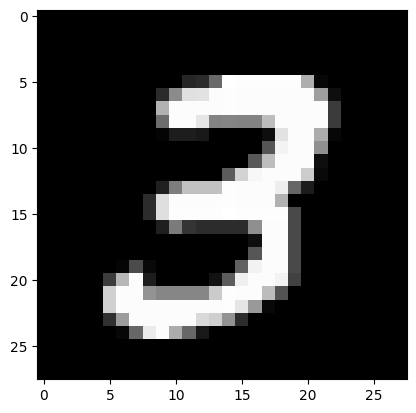

In [4]:
sample_num = 7
print("label: {}".format(train_labels[sample_num]))
plt.imshow(train_images[sample_num], cmap='gray')

In [5]:
# scale images to 0 - 1 range
train_images = train_images / 255
test_images = test_images / 255
print(len(np.unique(train_labels)))

10


In [15]:
model_type = "fnn" # cnn, fnn

tf.keras.backend.clear_session()

if model_type == "cnn":
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(2, 3, activation="relu",input_shape=(28,28,1), name="cnn_l1"),
        tf.keras.layers.MaxPooling2D(2, name="cnn_l2"),
        tf.keras.layers.Conv2D(2, 3,activation="relu", name="cnn_l3"),
        tf.keras.layers.MaxPooling2D(2, name="cnn_l4"),
        tf.keras.layers.Flatten(name="cnn_l5"),
        tf.keras.layers.Dense(len(np.unique(train_labels)), name="cnn_l6"),
    ])
elif model_type == "fnn":
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28,1),name="fnn_l1"),
        tf.keras.layers.Dense(16, activation='relu',name="fnn_l2"),
        tf.keras.layers.Dense(len(np.unique(train_labels)), name="fnn_l3"),
    ])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

model.fit(train_images, train_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fnn_l1 (Flatten)            (None, 784)               0         
                                                                 
 fnn_l2 (Dense)              (None, 16)                12560     
                                                                 
 fnn_l3 (Dense)              (None, 10)                170       
                                                                 
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4386 - accuracy: 0.8749
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2376 - accuracy: 0.9316
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2045 - accuracy: 0.9422
Epoch 4/5
187

# That was mnist / Fmnist, now for something harder with COCO
